# A quick demo showing computation with different strategies

In particular, I want to show how the different sequential decision making strategies evolve differently during their iteration.

In [1]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.linalg import cho_solve, cho_factor, solve_triangular
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

### Reusing objects from before, and adding some new computations

Again, we should be importing these from a central source.  But we're copying things here to make the notebooks independent.  We also have to implement a few extra things in order to permit the kinds of iteration that we want (in particular, posterior draws from the Gaussian process).

In addition to Expected Improvement, I'm also adding other "acquisition functions" to allow the demonstration below.  Some of these require some sense of point diversity, which I simply deal with by treating all the points under consideration on a grid.  This is not ideal in all settings, but will work fine for our purposes here.

In [46]:
class GaussianProcess(object):
    def __init__(self, x, y, process_variance, length_scales, observation_noise):
        length_scales = np.array(length_scales)
        x = np.copy(x)
        y = np.copy(y)
        assert process_variance > 0 and observation_noise >= 0 and all(length_scales > 0)
        assert len(x.shape) == 2 and len(y.shape) == 1 and len(length_scales) == x.shape[1] and x.shape[0] == len(y)
        
        self.x = x
        self.y = y
        self.length_scales = length_scales
        self.process_variance = process_variance
        self.observation_noise = observation_noise
        
        self._distance_matrix_weights = 1 / self.length_scales ** 2
        self._interpolation_weights = None
        self._K_chol = None
        self._initialize()
        
    @property
    def dim(self):
        return self.x.shape[1]
        
    @property
    def num_points(self):
        return self.x.shape[0]
        
    @property
    def max_value(self):
        return np.max(self.y)
        
    def _initialize(self):
        K = self.compute_covariance(self.x, self.x)
        self._K_chol = cho_factor(K + np.eye(self.num_points) * self.observation_noise, lower=True, overwrite_a=True)
        self._interpolation_weights = cho_solve(self._K_chol, self.y)
    
    def _distance_matrix_squared(self, x, z):
        return cdist(x, z, w=self._distance_matrix_weights, metric='sqeuclidean')
    
    def compute_covariance(self, x, z):
        r_squared = self._distance_matrix_squared(x, z)
        return self.process_variance * np.exp(-r_squared)
    
    def posterior_mean(self, x):
        K_eval = self.compute_covariance(x, self.x)
        return np.dot(K_eval, self._interpolation_weights)
    
    def posterior_variance(self, x):
        K_eval = self.compute_covariance(x, self.x)
        symmetric_term = solve_triangular(self._K_chol[0], K_eval.T, lower=self._K_chol[1], overwrite_b=True)
        schur_complement_term = np.sum(symmetric_term ** 2, axis=0)
        return np.fmax(1e-20, self.process_variance - schur_complement_term)
    
    def posterior_draws(self, x, num_samples):
        mean = self.posterior_mean(x)
        cov = self.compute_covariance_of_points(x)
        # We add a little fudge factor to the diagonal to avoid having to do any SVD stuff
        L = np.linalg.cholesky(cov + .1 * self.observation_noise * np.eye(len(cov)))
        z_samples = np.atleast_2d(np.random.normal(size=(len(mean), num_samples)))
        return mean[None, :] + np.transpose(np.dot(L, z_samples))
    
    def compute_covariance_of_points(self, x):
        K_eval_var = self.compute_covariance(x, x)
        K_eval = self.compute_covariance(x, self.x)
        V = solve_triangular(self._K_chol[0], K_eval.T, lower=self._K_chol[1], overwrite_b=True)
        return K_eval_var - np.dot(V.T, V)
    
    def add_one_point(self, new_x, new_y):
        self.x = np.concatenate((self.x, new_x[None, :]), axis=0)
        self.y = np.concatenate((self.y, [new_y]), axis=0)
        self._initialize()

def expected_improvement(gaussian_process, x):
    mean = gaussian_process.posterior_mean(x)
    sqrt_var = np.sqrt(gaussian_process.posterior_variance(x))
    z = (mean - gaussian_process.max_value) / sqrt_var
    return sqrt_var * np.fmax(0.0, z * norm.cdf(z) + norm.pdf(z))

def probability_of_success(gaussian_process, x, threshold):
    mean = gaussian_process.posterior_mean(x)
    sqrt_var = np.sqrt(gaussian_process.posterior_variance(x))
    z_success = (mean - threshold) / sqrt_var
    return norm.cdf(z_success)

# This can serve for both active learning (highest entropy) and Bayesian cubature (maximize variance)
# Other strategies certainly exist, but I figured I would keep it a bit simpler here
def dpp_for_one_next_point(gaussian_process, x):
    return gaussian_process.posterior_variance(x)

Note that, in addition to the plotting stuff from earlier, we also define new terms.  One of them is the `threshold` idea which defines success in the search problem (finding outcomes greater than a given threshold).  The other set of points that we have introduced are a fixed set of points on which to consider during the optimization.  Each method gets its own discrete set of points, which helps us define success in the search problem (since points could be repeated otherwise).

This creation of a discrete domain is not required but it will make our lives easier for a simple demonstration.  In a better design, this could be hidden inside the GP object, but that sort of seems unnecessary here.

In [51]:
def yf(x):
    x1, x2 = np.array(x).T
    return (
        .75 * np.exp(-.25 * ((9 * x1 - 2) ** 2 + (9 * x2 - 2) ** 2)) +
        .75 * np.exp(-(9 * x1 + 1) ** 2 / 49 - (9 * x2 + 1) / 10) +
        .5 * np.exp(-.25 * ((9 * x1 - 7) ** 2 + (9 * x2 - 3) ** 2)) -
        .2 * np.exp(-(9 * x1 - 4) ** 2 - (9 * x2 - 7) ** 2)
    )

Np = (35, 34)
X0, X1 = np.meshgrid(np.linspace(0, 1, Np[1]), np.linspace(0, 1, Np[0]))
xp = np.array([X0.reshape(-1), X1.reshape(-1)]).T
yp = yf(xp)
Y = yp.reshape(Np)

threshold = 0.85

c:\users\mike\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


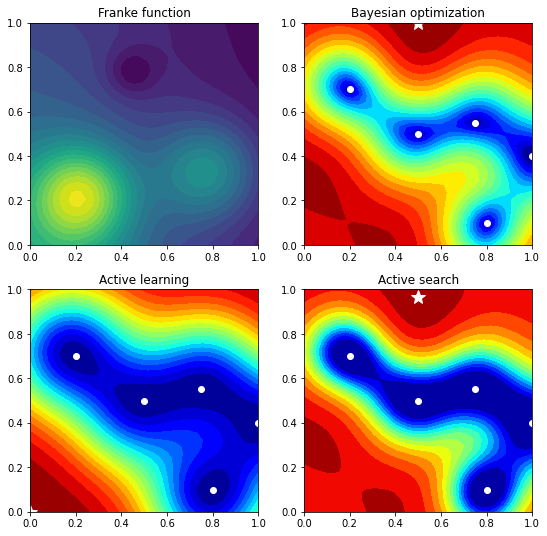

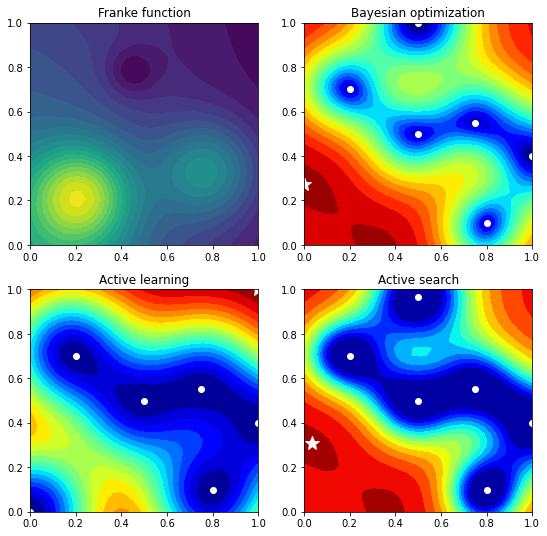

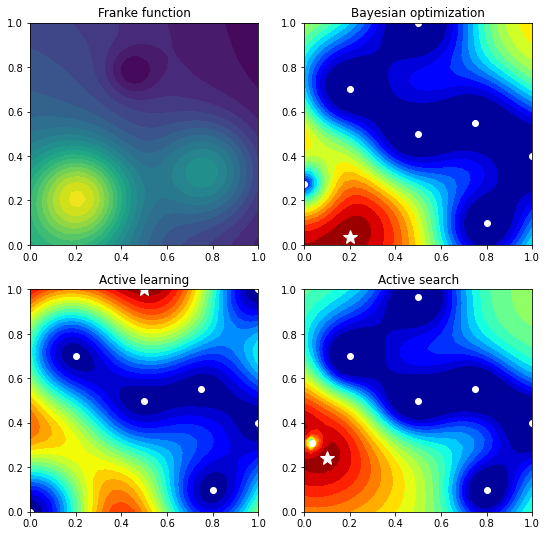

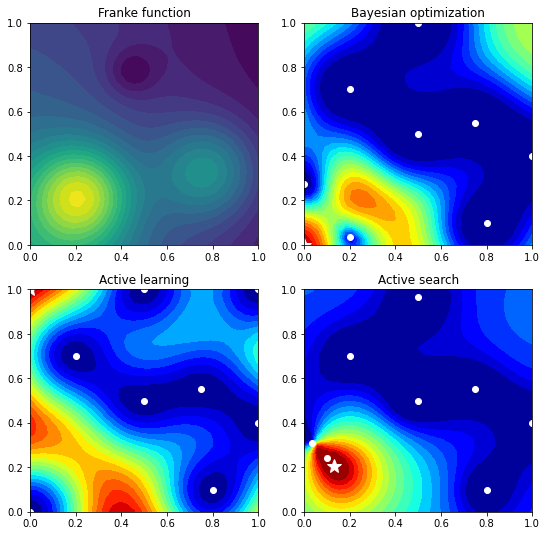

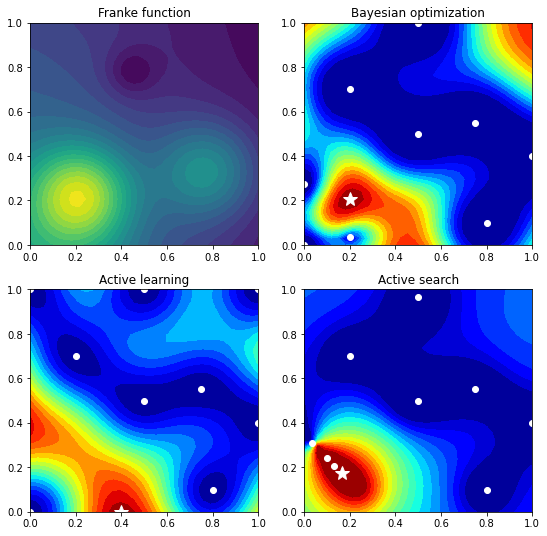

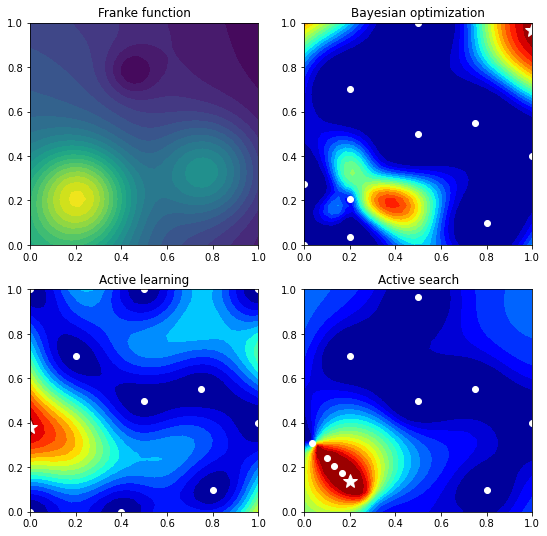

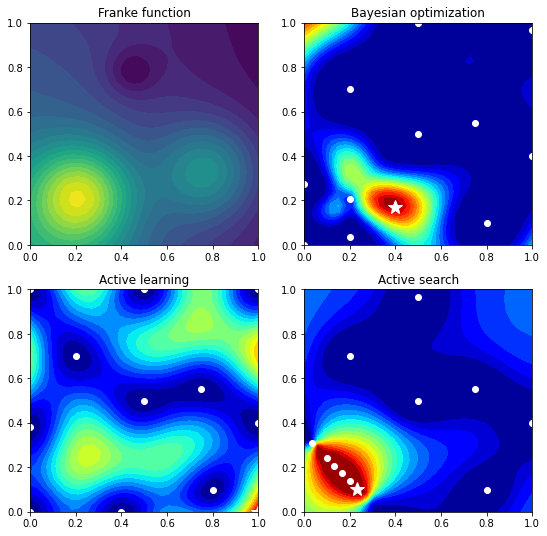

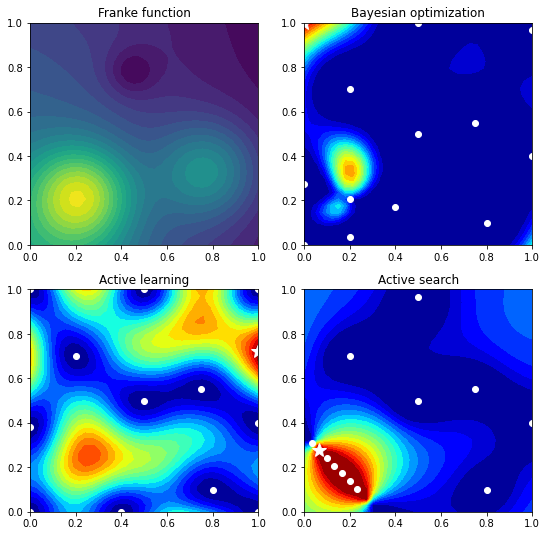

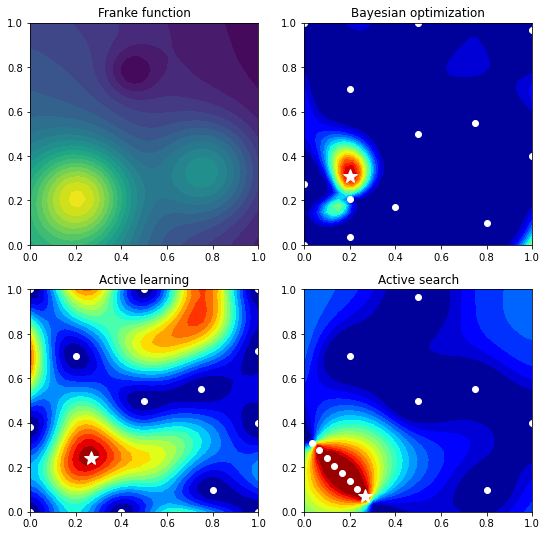

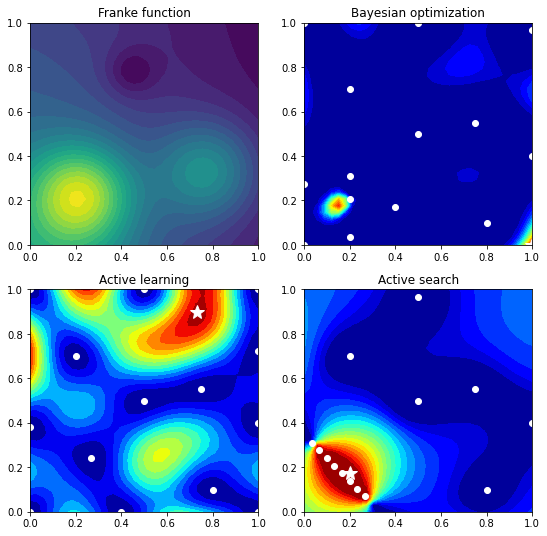

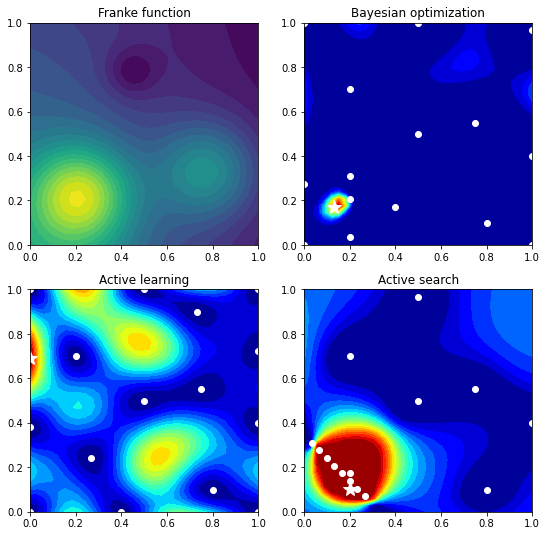

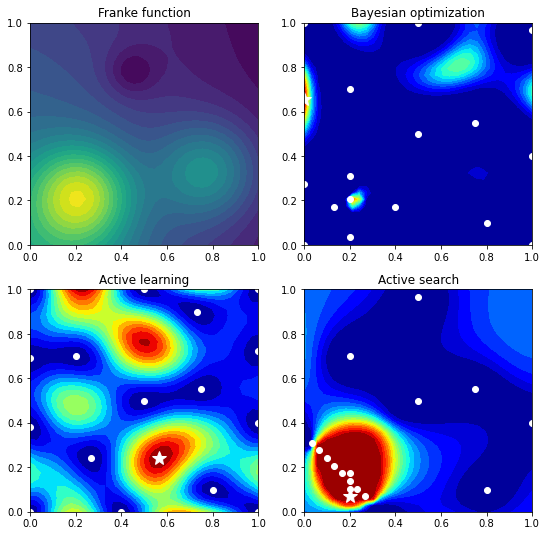

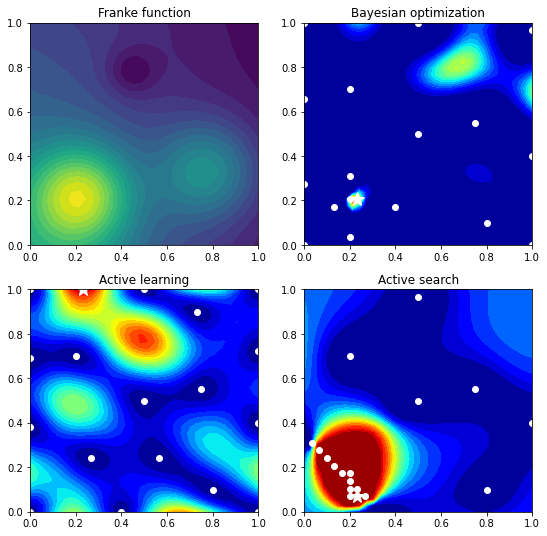

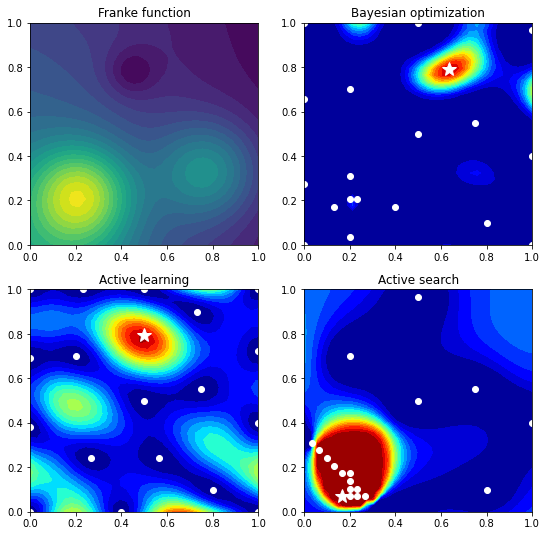

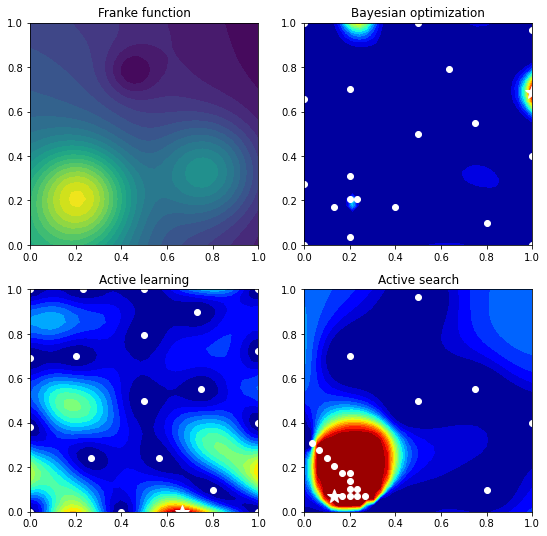

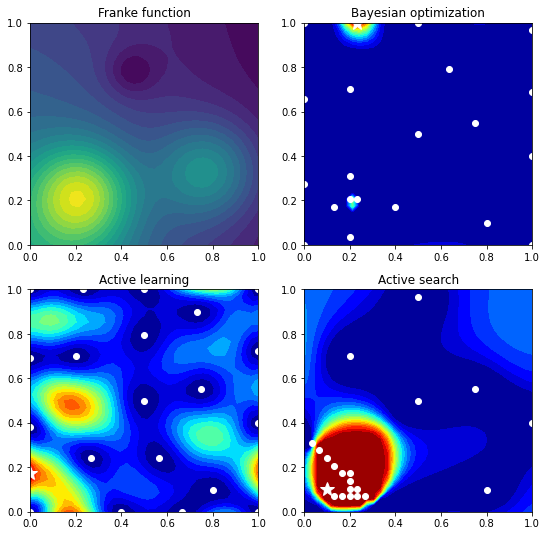

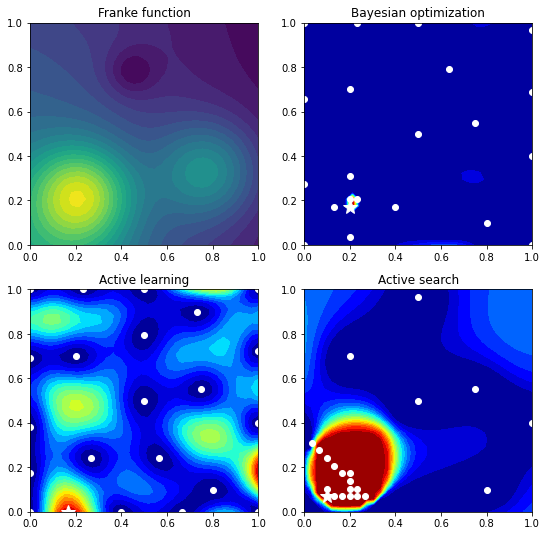

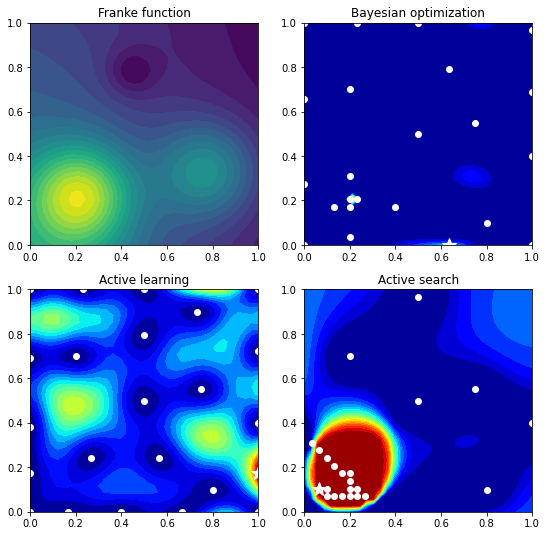

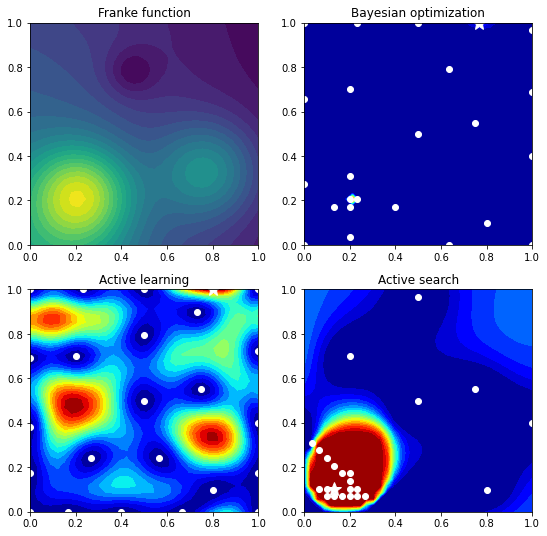

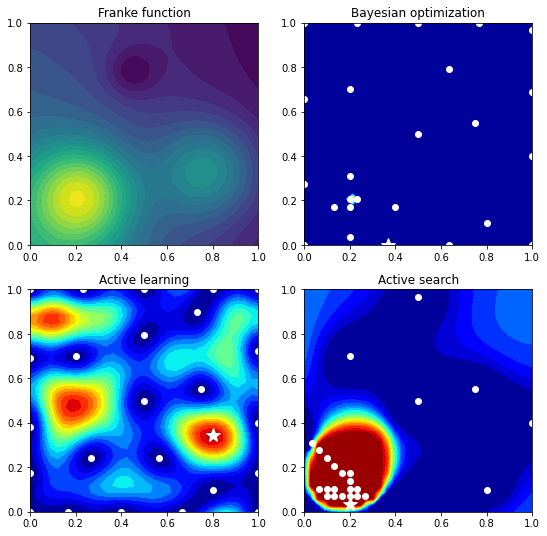

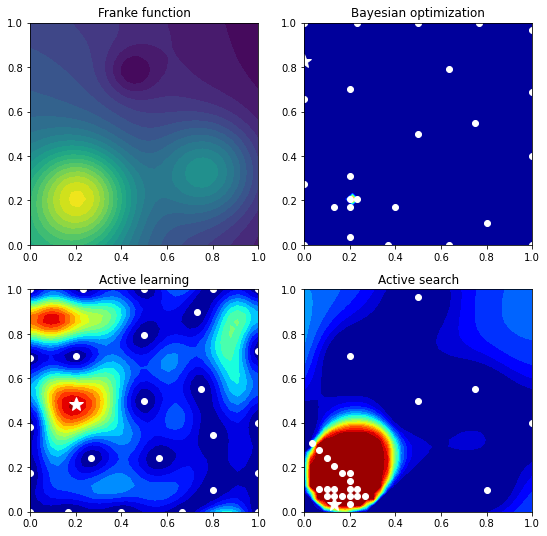

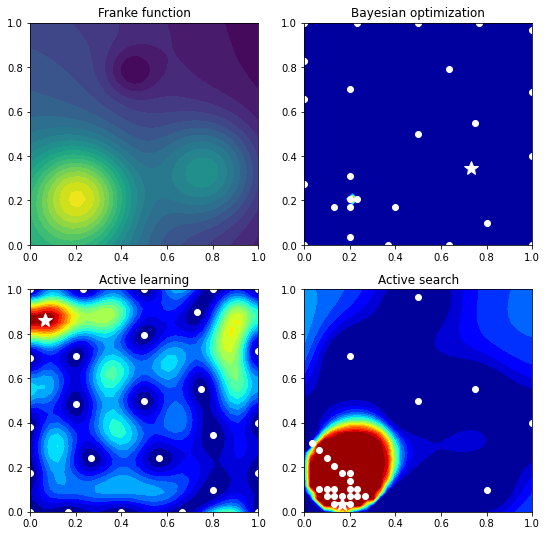

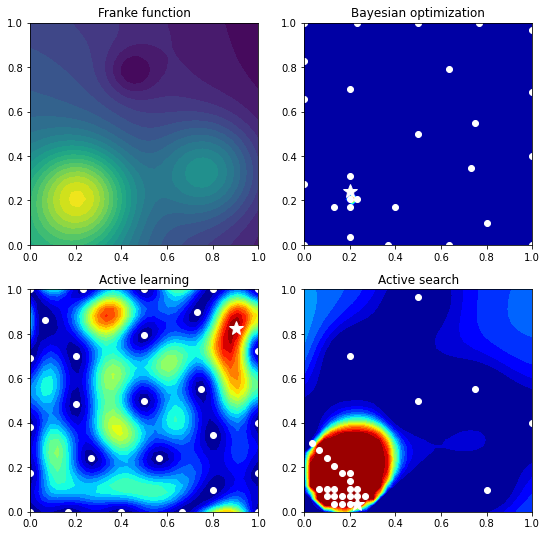

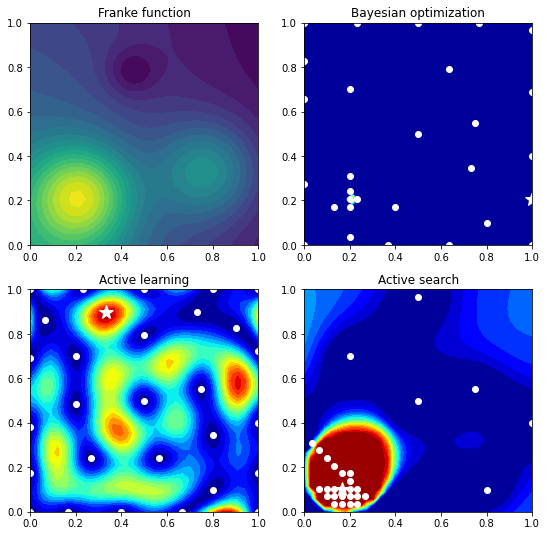

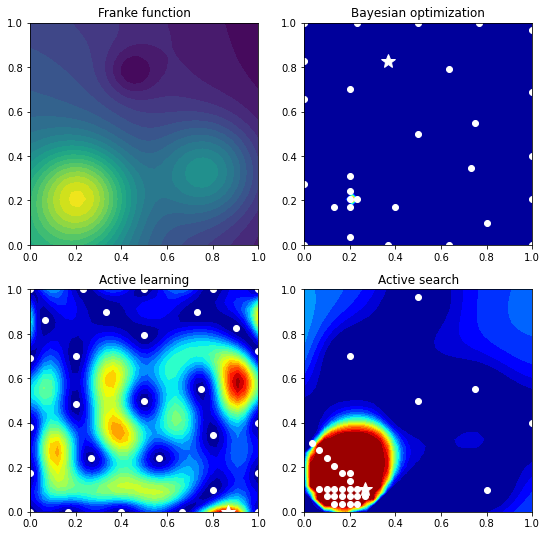

In [73]:
# This is the set of test points for each sequential decision making problem.
XT0, XT1 = np.meshgrid(np.linspace(0, 1, 31), np.linspace(0, 1, 30))
xt_bo = np.array([XT0.reshape(-1), XT1.reshape(-1)]).T
xt_as = np.copy(xt_bo)
xt_al = np.copy(xt_bo)

x_base = np.array([[.2, .7], [.8, .1], [.5, .5], [1, .4], [.75, .55]])
y_base = yf(x_base)

process_variance = 1.0
length_scales = [.4] * 2
observation_noise = 1e-5
gp_bo = GaussianProcess(x_base, y_base, process_variance, length_scales, observation_noise)
gp_as = GaussianProcess(x_base, y_base, process_variance, length_scales, observation_noise)
gp_al = GaussianProcess(x_base, y_base, process_variance, length_scales, observation_noise)

while gp_bo.num_points < 30:
    EI = expected_improvement(gp_bo, xp).reshape(Np)
    PS = probability_of_success(gp_as, xp, threshold).reshape(Np)
    MV = dpp_for_one_next_point(gp_al, xp).reshape(Np)
    
    fig, axes = plt.subplots(2, 2, figsize=(9, 9))

    
    ax = axes[0, 0]
    ax.contourf(X0, X1, Y, 20)
    ax.set_title('Franke function')

    
    ax = axes[0, 1]
    h = ax.contourf(X0, X1, EI, 20, cmap='jet')
    ax.plot(gp_bo.x[:, 0], gp_bo.x[:, 1], 'ow')
    ax.set_title('Bayesian optimization')
    
    ei = expected_improvement(gp_bo, xt_bo)
    winning_index = np.argmax(ei)
    next_point = xt_bo[winning_index, :]
    xt_bo = np.delete(xt_bo, winning_index, axis=0)
    next_value = yf(next_point[None, :])[0]
    gp_bo.add_one_point(next_point, next_value)
    ax.plot(next_point[0], next_point[1], 'w*', markersize=14)

    
    ax = axes[1, 0]
    h = ax.contourf(X0, X1, MV, 20, cmap='jet')
    ax.plot(gp_al.x[:, 0], gp_al.x[:, 1], 'ow')
    ax.set_title('Active learning')
    
    mv = dpp_for_one_next_point(gp_al, xt_al)
    winning_index = np.argmax(mv)
    next_point = xt_al[winning_index, :]
    xt_al = np.delete(xt_al, winning_index, axis=0)
    next_value = yf(next_point[None, :])[0]
    gp_al.add_one_point(next_point, next_value)
    ax.plot(next_point[0], next_point[1], 'w*', markersize=14)

    
    ax = axes[1, 1]
    h = ax.contourf(X0, X1, PS, 20, cmap='jet')
    ax.plot(gp_as.x[:, 0], gp_as.x[:, 1], 'ow')
    ax.set_title('Active search')
    
    ps = probability_of_success(gp_as, xt_as, threshold)
    winning_index = np.argmax(ps)
    next_point = xt_as[winning_index, :]
    xt_as = np.delete(xt_as, winning_index, axis=0)
    next_value = yf(next_point[None, :])[0]
    gp_as.add_one_point(next_point, next_value)
    ax.plot(next_point[0], next_point[1], 'w*', markersize=14)
    
    plt.savefig(f'comparison_{gp_bo.num_points}.png')